## Description
Attached you find a randomly sampled extract of some of our policies.
We want to be able to predict the "number_of_payment_faults" 
(this is the number of payment attempts which failed when we try to charge the money for the policy from the customer) in the future for each new policy.
There is a small legend in the document to describe some of the fields.
If there are open questions about the data you can't answer by yourself do not hesitate to approach us!
Feel free to use whatever tool or language you feel comfortable with to solve the task.

## Task
Create a statistical model to predict the "number_of_payment_faults" for a policy.
There is no fixed or expected outcome what we want to see from you. 
We prefer quality over speed. 
It does not only matter if your solution yields correct results, but also your overall project structure, tools used, etc.


In [1]:
import collections

import math

from datetime import datetime

import statsmodels.formula.api as smf

import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype

import numpy as np
from numpy import inf

from scipy import stats
from scipy.stats import skew, norm
from scipy.stats import randint as sp_randint
from scipy.special import boxcox1p

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

import lightgbm as lgb

from hyperopt import hp, tpe, STATUS_OK, Trials
from hyperopt.fmin import fmin

import warnings
warnings.filterwarnings("ignore")
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory

np.random.seed(42)

/Users/kai/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## 1. Load Data

In [2]:
df_friday = pd.read_excel('Your_Dataset.xlsx')

In [3]:
df_friday.shape

(27950, 18)

In [4]:
df_friday.head(20)

,contract_nr,sf_class_tpl,sf_class_fc,age_insured_person,policy_start,tariff_type,type_of_insurance,comprehensive_product,fc_deductible,pc_deductible,payment_interval,insured_parties,profession_group,car_age_at_purchase,car_age_contract_start,annual_mileage,risk_predictor_zip_code,number_of_payment_faults
0,1,SF1/2,SF1/2,34,YOB,Original,New Vehicle,NaN,0,0,Monthly,Insured and Spouse/Partner,Standard,10,11,12000,5.000,1.000
1,2,SF31,SF31,55,YOB,Original,Change of Insurer,NaN,0,0,Pay In Full,Insured and Spouse/Partner,Standard,2,7,9000,6.000,nan
2,3,SF5,SF5,52,YOB,Original,New Vehicle,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,11,12,20000,1.000,nan
3,4,SF15,SF15,41,YEB,Original,Change of Insurer,TK,0,150,Monthly,Insured and Spouse/Partner,Standard,0,9,15000,6.000,nan
4,5,SF17,SF18,42,YOB,Original,Change of Insurer,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,0,2,15000,3.000,nan
5,6,SF7,SF13,37,YOB,Original,New Vehicle,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,0,0,15000,7.000,nan
6,7,SF9,SF9,37,YEB,Original,Change of Insurer,VK,300,300,Monthly,Insured and Spouse/Partner,Standard,0,2,9000,7.000,nan
7,8,SF3,SF3,22,YEB,Pay per km,Change of Insurer,VK,300,150,Monthly,Insured and Others,Standard,0,3,6000,3.000,nan
8,9,SF19,SF14,78,YOB,Original,Change of Insurer,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,0,3,6000,1.000,nan
9,10,SF4,SF4,34,YEB,Original,Change of Insurer,VK,500,150,Monthly,Insured and Spouse/Partner,Standard,0,3,6000,6.000,nan


In [5]:
df_train = df_friday[df_friday['number_of_payment_faults'].notnull()]

In [6]:
df_test = df_friday[df_friday['number_of_payment_faults'].isnull()]

In [7]:
df_train.shape

(4789, 18)

In [8]:
df_test.shape

(23161, 18)

In [9]:
df_train.head()

,contract_nr,sf_class_tpl,sf_class_fc,age_insured_person,policy_start,tariff_type,type_of_insurance,comprehensive_product,fc_deductible,pc_deductible,payment_interval,insured_parties,profession_group,car_age_at_purchase,car_age_contract_start,annual_mileage,risk_predictor_zip_code,number_of_payment_faults
0,1,SF1/2,SF1/2,34,YOB,Original,New Vehicle,NaN,0,0,Monthly,Insured and Spouse/Partner,Standard,10,11,12000,5.000,1.000
33,34,SF5,SF5,47,YOB,Original,New Vehicle,TK,0,150,Monthly,Insured and Spouse/Partner,Standard,8,9,9000,8.000,1.000
35,36,SF1/2,SF1/2,37,YOB,Original,First Vehicle,NaN,0,0,Monthly,Insured and Spouse/Partner,Standard,15,16,6000,5.000,2.000
38,39,SF1/2,SF1/2,42,YOB,Original,Change of Insurer,TK,0,150,Monthly,Insured and Spouse/Partner,Standard,1,2,15000,1.000,2.000
47,48,SF23,SF3,63,YEB,Pay per km,Change of Insurer,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,4,5,12000,5.000,1.000


In [10]:
df_test.head()

,contract_nr,sf_class_tpl,sf_class_fc,age_insured_person,policy_start,tariff_type,type_of_insurance,comprehensive_product,fc_deductible,pc_deductible,payment_interval,insured_parties,profession_group,car_age_at_purchase,car_age_contract_start,annual_mileage,risk_predictor_zip_code,number_of_payment_faults
1,2,SF31,SF31,55,YOB,Original,Change of Insurer,NaN,0,0,Pay In Full,Insured and Spouse/Partner,Standard,2,7,9000,6.000,nan
2,3,SF5,SF5,52,YOB,Original,New Vehicle,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,11,12,20000,1.000,nan
3,4,SF15,SF15,41,YEB,Original,Change of Insurer,TK,0,150,Monthly,Insured and Spouse/Partner,Standard,0,9,15000,6.000,nan
4,5,SF17,SF18,42,YOB,Original,Change of Insurer,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,0,2,15000,3.000,nan
5,6,SF7,SF13,37,YOB,Original,New Vehicle,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,0,0,15000,7.000,nan


In [11]:
df_train[df_train['number_of_payment_faults'].isnull()].shape

(0, 18)

## 2. EDA and Data Processing

In [12]:
df_friday.head()

,contract_nr,sf_class_tpl,sf_class_fc,age_insured_person,policy_start,tariff_type,type_of_insurance,comprehensive_product,fc_deductible,pc_deductible,payment_interval,insured_parties,profession_group,car_age_at_purchase,car_age_contract_start,annual_mileage,risk_predictor_zip_code,number_of_payment_faults
0,1,SF1/2,SF1/2,34,YOB,Original,New Vehicle,NaN,0,0,Monthly,Insured and Spouse/Partner,Standard,10,11,12000,5.000,1.000
1,2,SF31,SF31,55,YOB,Original,Change of Insurer,NaN,0,0,Pay In Full,Insured and Spouse/Partner,Standard,2,7,9000,6.000,nan
2,3,SF5,SF5,52,YOB,Original,New Vehicle,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,11,12,20000,1.000,nan
3,4,SF15,SF15,41,YEB,Original,Change of Insurer,TK,0,150,Monthly,Insured and Spouse/Partner,Standard,0,9,15000,6.000,nan
4,5,SF17,SF18,42,YOB,Original,Change of Insurer,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,0,2,15000,3.000,nan


In [13]:
df_friday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27950 entries, 0 to 27949
Data columns (total 18 columns):
contract_nr                 27950 non-null int64
sf_class_tpl                27950 non-null object
sf_class_fc                 27950 non-null object
age_insured_person          27950 non-null int64
policy_start                27940 non-null object
tariff_type                 27950 non-null object
type_of_insurance           27950 non-null object
comprehensive_product       20355 non-null object
fc_deductible               27950 non-null int64
pc_deductible               27950 non-null int64
payment_interval            27950 non-null object
insured_parties             27950 non-null object
profession_group            27950 non-null object
car_age_at_purchase         27950 non-null int64
car_age_contract_start      27950 non-null int64
annual_mileage              27950 non-null int64
risk_predictor_zip_code     27948 non-null float64
number_of_payment_faults    4789 non-null float

In [14]:
df_friday.shape

(27950, 18)

- ### Missing Data Analysis

#### Check percentage of missing data

If more than 50% of the data is missing, we should delete the corresponding variable and pretend it never existed. 

In [15]:
all_data_na = (df_train.isnull().sum() / len(df_train)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
comprehensive_product,49.113
policy_start,0.063
risk_predictor_zip_code,0.021


Text(0.5, 1.0, 'Percent missing data by feature')

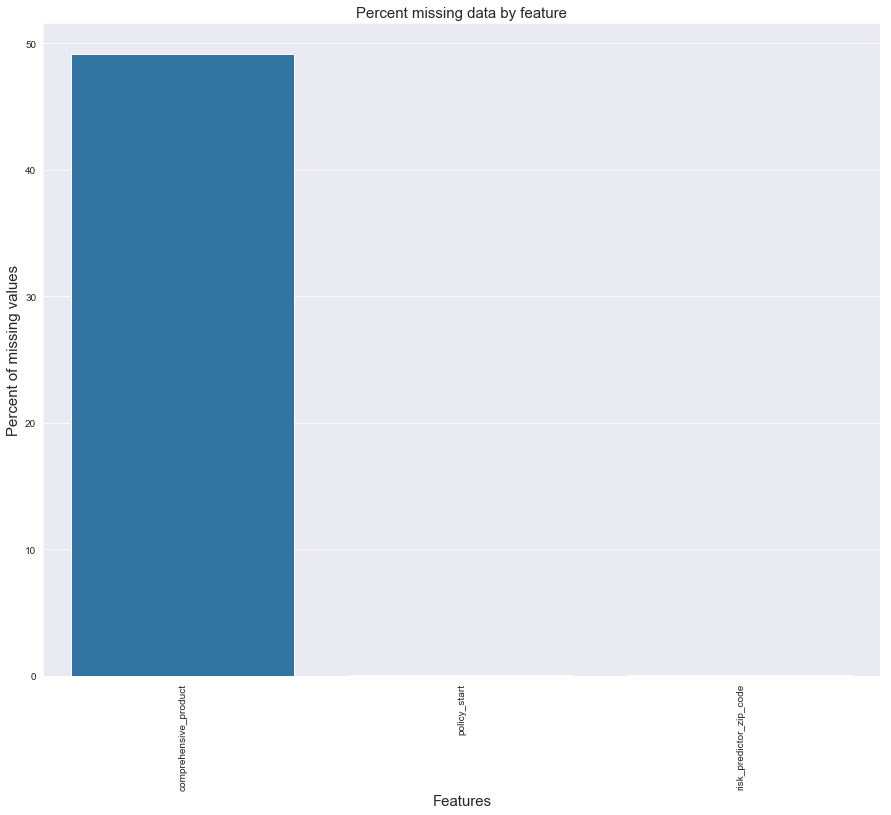

In [16]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [17]:
df_train['comprehensive_product'].describe()

count     2437
unique       2
top         TK
freq      1246
Name: comprehensive_product, dtype: object

In [18]:
df_train['comprehensive_product'].unique()

array([nan, 'TK', 'VK'], dtype=object)

I will keep all the features.

### 'sf_class_tpl' 

In [19]:
df_train['sf_class_tpl'].describe()

count      4789
unique       47
top       SF1/2
freq       1805
Name: sf_class_tpl, dtype: object

In [20]:
df_train['sf_class_tpl'].unique()

array(['SF1/2', 'SF5', 'SF23', 'SF1', 'SF18', 'SF35', 'SF10', 'SF2',
       'SF17', 0, 'SF19', 'SF24', 'SF13', 'SF14', 'SF8', 'SF7', 'SF21',
       'SF3', 'SF4', 'SF15', 'SF22', 'SF9', 'SF12', 'M', 'SF27', 'SF6',
       'SF16', 'SF11', 'SF28', 'SF37', 'SF20', 'SF30', 'SF31', 'SF34',
       'SF26', 'SF25', 'SF33', 'SF39', 'SF32', 'SF36', 'SF29', 'SF44',
       'SF42', 'SF41', 'SF40', 'SF38', 'S'], dtype=object)

In [21]:
df_train[df_train['sf_class_tpl'].isnull()].shape

(0, 18)

### 'sf_class_fc'

In [22]:
df_train['sf_class_fc'].describe()

count      4789
unique       47
top       SF1/2
freq       1834
Name: sf_class_fc, dtype: object

In [23]:
df_train['sf_class_fc'].unique()

array(['SF1/2', 'SF5', 'SF3', 'SF1', 'SF18', 'SF35', 'SF10', 'SF2',
       'SF22', 0, 'SF19', 'SF24', 'SF25', 'SF16', 'SF15', 'SF14', 'SF8',
       'SF7', 'SF21', 'SF4', 'SF23', 'SF9', 'M', 'SF12', 'SF13', 'SF6',
       'SF27', 'SF17', 'SF11', 'SF28', 'SF37', 'SF30', 'SF33', 'SF31',
       'SF34', 'SF20', 'SF26', 'SF29', 'SF32', 'SF36', 'SF41', 'SF44',
       'SF42', 'S', 'SF39', 'SF40', 'SF38'], dtype=object)

In [24]:
df_train[df_train['sf_class_fc'].isnull()].shape

(0, 18)

### 'policy_start'

In [25]:
df_train['policy_start'].describe()

count     4786
unique       2
top        YOB
freq      3362
Name: policy_start, dtype: object

In [26]:
df_train['policy_start'].unique()

array(['YOB', 'YEB', nan], dtype=object)

In [27]:
df_train[df_train['policy_start'].isnull()].shape

(3, 18)

### 'tariff_type'

In [28]:
df_train['tariff_type'].describe()

count         4789
unique           2
top       Original
freq          3816
Name: tariff_type, dtype: object

In [29]:
df_train['tariff_type'].unique()

array(['Original', 'Pay per km'], dtype=object)

In [30]:
df_train[df_train['tariff_type'].isnull()].shape

(0, 18)

### 'type_of_insurance'

In [31]:
df_train['type_of_insurance'].describe()

count                  4789
unique                    3
top       Change of Insurer
freq                   2594
Name: type_of_insurance, dtype: object

In [32]:
df_train['type_of_insurance'].unique()

array(['New Vehicle', 'First Vehicle', 'Change of Insurer'], dtype=object)

In [33]:
df_train[df_train['type_of_insurance'].isnull()].shape

(0, 18)

### 'payment_interval'

In [34]:
df_train['payment_interval'].describe()

count        4789
unique          2
top       Monthly
freq         4722
Name: payment_interval, dtype: object

In [35]:
df_train['payment_interval'].unique()

array(['Monthly', 'Pay In Full'], dtype=object)

In [36]:
df_train[df_train['payment_interval'].isnull()].shape

(0, 18)

### 'insured_parties'

In [37]:
df_train['insured_parties'].describe()

count                           4789
unique                             2
top       Insured and Spouse/Partner
freq                            3951
Name: insured_parties, dtype: object

In [38]:
df_train['insured_parties'].unique()

array(['Insured and Spouse/Partner', 'Insured and Others'], dtype=object)

In [39]:
df_train[df_train['insured_parties'].isnull()].shape

(0, 18)

### 'profession_group'

In [40]:
df_train['profession_group'].describe()

count         4789
unique           2
top       Standard
freq          4369
Name: profession_group, dtype: object

In [41]:
df_train['profession_group'].unique()

array(['Standard', 'Public service'], dtype=object)

In [42]:
df_train[df_train['profession_group'].isnull()].shape

(0, 18)

### 'age_insured_person'

In [43]:
def report_numerical_variables(df_friday, var_name):
    print('-------------')
    print(var_name)
    print('\n')
    
    print(df_friday[var_name].describe())
    
    sns.distplot(df_friday[var_name])
    
    #skewness and kurtosis
    print("Skewness: %f" % df_friday[var_name].skew())

    df_friday[[var_name]].boxplot()
    pyplot.show()

    df_friday[[var_name]].hist()
    pyplot.show()

    print('mean: {} median: {}'.format(df_friday[var_name].mean(), df_friday[var_name].median()))

    df_friday[df_friday[var_name].isnull()].shape

    sns.distplot(df_friday[var_name], fit=norm)
    fig = plt.figure()

    # https://matplotlib.org/mpl-probscale/tutorial/closer_look_at_viz.html
    res = stats.probplot(df_friday[var_name], plot=plt)
    
    num_null = df_friday[df_friday[var_name].isnull()].shape[0]
    print('number of null rows: {}'.format(num_null))


-------------
age_insured_person


count   4789.000
mean      41.868
std       13.748
min       18.000
25%       31.000
50%       40.000
75%       51.000
max       91.000
Name: age_insured_person, dtype: float64
Skewness: 0.654636


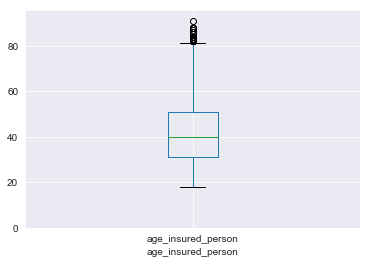

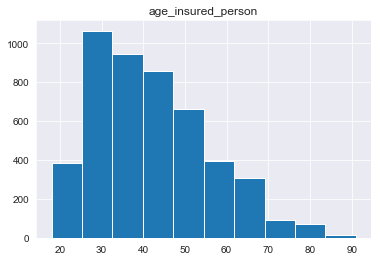

mean: 41.867822092294844 median: 40.0
number of null rows: 0


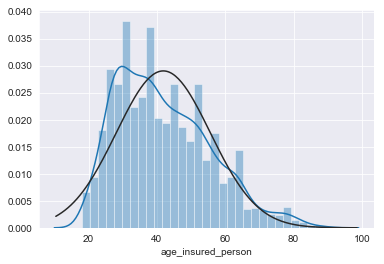

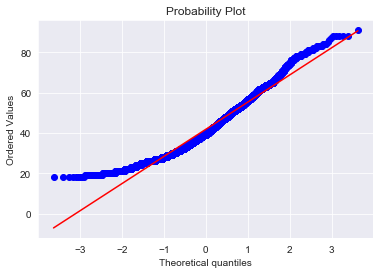

In [44]:
report_numerical_variables(df_train, 'age_insured_person')

### 'fc_deductible'

-------------
fc_deductible


count   4789.000
mean      91.334
std      179.384
min        0.000
25%        0.000
50%        0.000
75%        0.000
max     1000.000
Name: fc_deductible, dtype: float64
Skewness: 2.406833


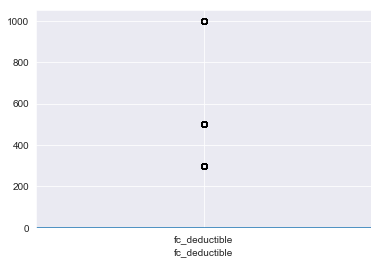

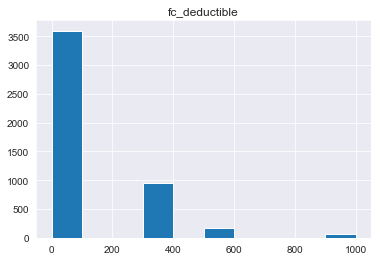

mean: 91.3343077886824 median: 0.0
number of null rows: 0


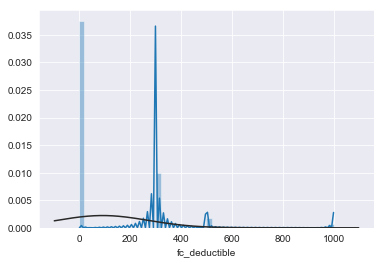

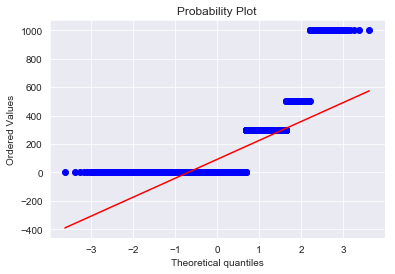

In [45]:
report_numerical_variables(df_train, 'fc_deductible')

### 'pc_deductible'

-------------
pc_deductible


count   4789.000
mean      85.519
std       93.411
min        0.000
25%        0.000
50%      150.000
75%      150.000
max      500.000
Name: pc_deductible, dtype: float64
Skewness: 0.897905


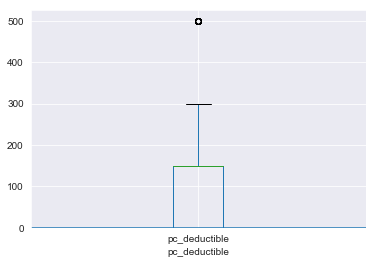

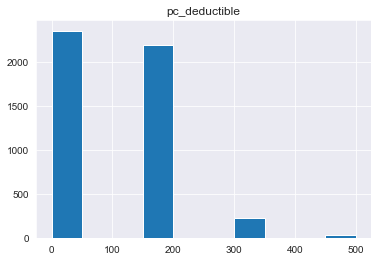

mean: 85.51889747337648 median: 150.0
number of null rows: 0


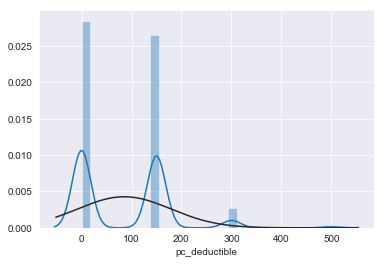

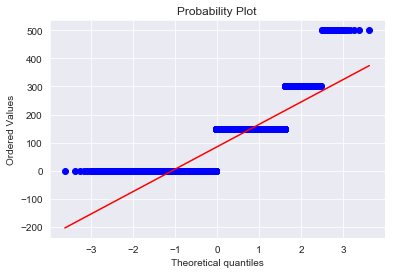

In [46]:
report_numerical_variables(df_train, 'pc_deductible')

### 'car_age_at_purchase'

-------------
car_age_at_purchase


count   4789.000
mean      10.342
std        7.086
min        0.000
25%        4.000
50%       11.000
75%       16.000
max       30.000
Name: car_age_at_purchase, dtype: float64
Skewness: -0.043320


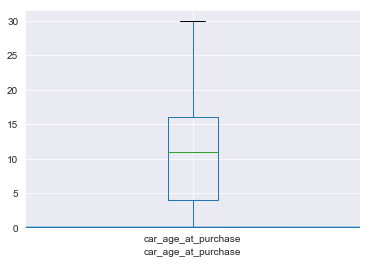

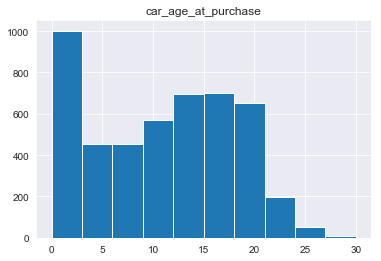

mean: 10.34245145124243 median: 11.0
number of null rows: 0


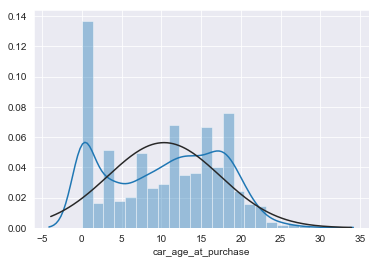

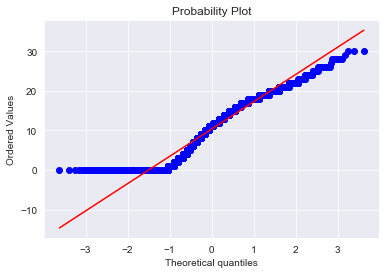

In [47]:
report_numerical_variables(df_train, 'car_age_at_purchase')

### 'car_age_contract_start'

-------------
car_age_contract_start


count   4789.000
mean      12.391
std        6.428
min        0.000
25%        8.000
50%       13.000
75%       18.000
max       31.000
Name: car_age_contract_start, dtype: float64
Skewness: -0.209361


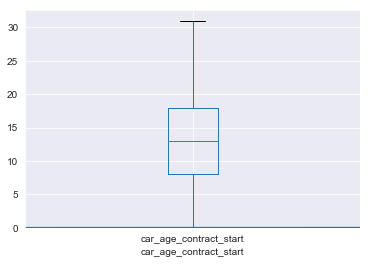

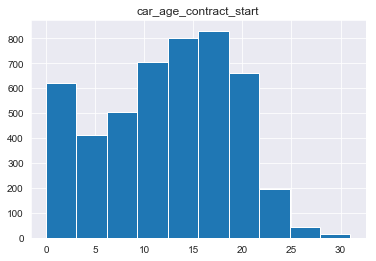

mean: 12.390895802881603 median: 13.0
number of null rows: 0


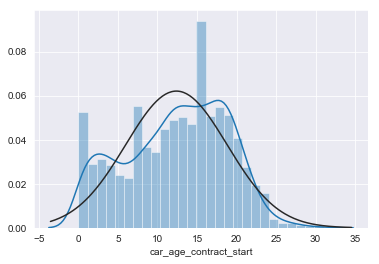

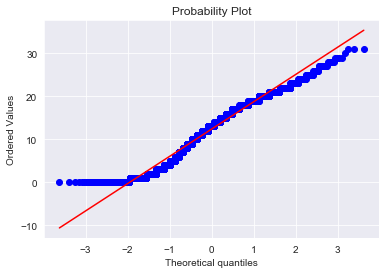

In [48]:
report_numerical_variables(df_train, 'car_age_contract_start')

### 'annual_mileage'

-------------
annual_mileage


count    4789.000
mean    12107.496
std      5734.010
min       600.000
25%      9000.000
50%     12000.000
75%     15000.000
max     90000.000
Name: annual_mileage, dtype: float64
Skewness: 1.791910


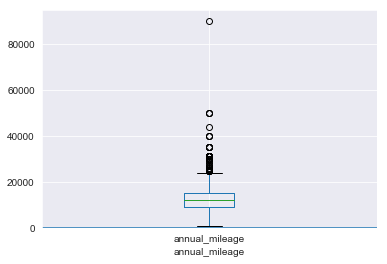

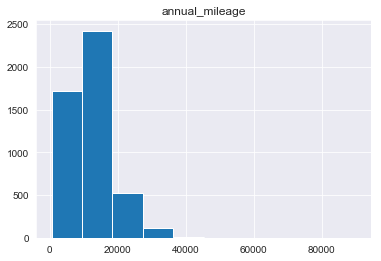

mean: 12107.49634579244 median: 12000.0
number of null rows: 0


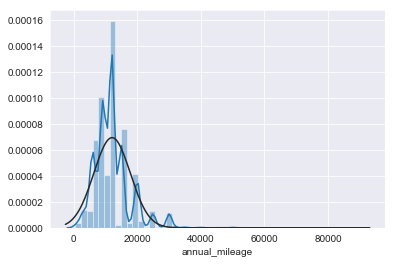

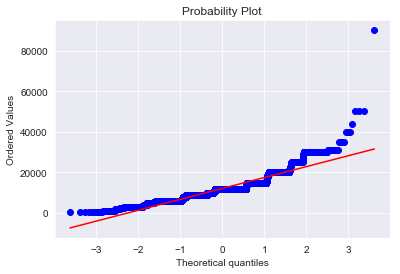

In [49]:
report_numerical_variables(df_train, 'annual_mileage')

### 'number_of_payment_faults' (target)

-------------
number_of_payment_faults


count   4789.000
mean       2.914
std        2.340
min        1.000
25%        1.000
50%        2.000
75%        4.000
max       17.000
Name: number_of_payment_faults, dtype: float64
Skewness: 1.548341


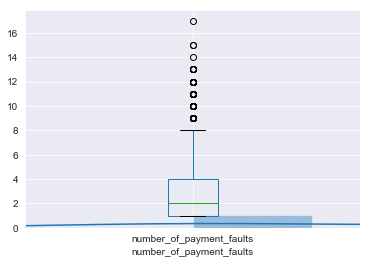

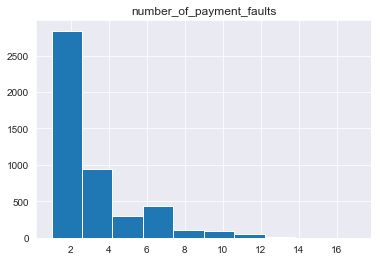

mean: 2.9141783253288787 median: 2.0
number of null rows: 0


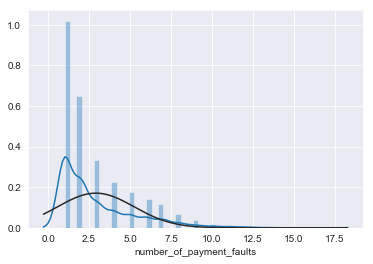

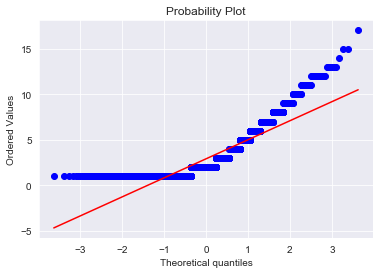

In [50]:
report_numerical_variables(df_train, 'number_of_payment_faults')

- ### Transforming some numerical variables that are really categorical
    - **'risk_predictor_zip_code'**

In [51]:
df_train['risk_predictor_zip_code'] = df_train['risk_predictor_zip_code'].apply(str)
df_test['risk_predictor_zip_code'] = df_test['risk_predictor_zip_code'].apply(str)

In [52]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4789 entries, 0 to 27944
Data columns (total 18 columns):
contract_nr                 4789 non-null int64
sf_class_tpl                4789 non-null object
sf_class_fc                 4789 non-null object
age_insured_person          4789 non-null int64
policy_start                4786 non-null object
tariff_type                 4789 non-null object
type_of_insurance           4789 non-null object
comprehensive_product       2437 non-null object
fc_deductible               4789 non-null int64
pc_deductible               4789 non-null int64
payment_interval            4789 non-null object
insured_parties             4789 non-null object
profession_group            4789 non-null object
car_age_at_purchase         4789 non-null int64
car_age_contract_start      4789 non-null int64
annual_mileage              4789 non-null int64
risk_predictor_zip_code     4789 non-null object
number_of_payment_faults    4789 non-null float64
dtypes: float64(

- ### Add new column '_na' for all the numerical variables

In [53]:
# handle the missing values: 
# - create a col_NA column to indicate which row has NAs.
def add_col_na(df_train, target):
    for col in df_train.columns:
        if col != target and is_numeric_dtype(df_train[col]):
            col_vals = df_train[col]
            if sum(col_vals.isnull()) != 0:
                df_train[col+'_na'] = col_vals.isnull()
                df_test[col+'_na'] = df_test[col].isnull()                
    return df_train, df_test

In [54]:
df_train, df_test = add_col_na(df_train, 'number_of_payment_faults')

In [55]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4789 entries, 0 to 27944
Data columns (total 18 columns):
contract_nr                 4789 non-null int64
sf_class_tpl                4789 non-null object
sf_class_fc                 4789 non-null object
age_insured_person          4789 non-null int64
policy_start                4786 non-null object
tariff_type                 4789 non-null object
type_of_insurance           4789 non-null object
comprehensive_product       2437 non-null object
fc_deductible               4789 non-null int64
pc_deductible               4789 non-null int64
payment_interval            4789 non-null object
insured_parties             4789 non-null object
profession_group            4789 non-null object
car_age_at_purchase         4789 non-null int64
car_age_contract_start      4789 non-null int64
annual_mileage              4789 non-null int64
risk_predictor_zip_code     4789 non-null object
number_of_payment_faults    4789 non-null float64
dtypes: float64(

- ### Skewness


Transform the skewed numeric features by taking log(feature + 1). This will make the features more normal.

https://www.kaggle.com/humananalog/xgboost-lasso/code

Other approaches:

Box Cox Transformation of (highly) skewed features

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [56]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4789 entries, 0 to 27944
Data columns (total 18 columns):
contract_nr                 4789 non-null int64
sf_class_tpl                4789 non-null object
sf_class_fc                 4789 non-null object
age_insured_person          4789 non-null int64
policy_start                4786 non-null object
tariff_type                 4789 non-null object
type_of_insurance           4789 non-null object
comprehensive_product       2437 non-null object
fc_deductible               4789 non-null int64
pc_deductible               4789 non-null int64
payment_interval            4789 non-null object
insured_parties             4789 non-null object
profession_group            4789 non-null object
car_age_at_purchase         4789 non-null int64
car_age_contract_start      4789 non-null int64
annual_mileage              4789 non-null int64
risk_predictor_zip_code     4789 non-null object
number_of_payment_faults    4789 non-null float64
dtypes: float64(

In [57]:
numeric_features = ['age_insured_person', 'fc_deductible', 'pc_deductible', 'car_age_at_purchase', 
                    'car_age_contract_start', 'annual_mileage'] 

In [58]:
#numeric_feats = df_train.dtypes[df_train.dtypes != "object"].index
#numeric_feats

In [59]:
#skewed = df_train[numeric_features].apply(lambda x: skew(x.dropna().astype(int)))
#skewed = skewed[skewed > 0.75]
#skewed = skewed.index

#df_train[skewed] = np.log1p(df_train[skewed])
#df_test[skewed]  = np.log1p(df_test[skewed])

In [60]:
#numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df_train[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
fc_deductible,2.406
annual_mileage,1.791
pc_deductible,0.898
age_insured_person,0.654
car_age_at_purchase,-0.043
car_age_contract_start,-0.209


In [61]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    df_train[feat] = boxcox1p(df_train[feat], lam)
    df_test[feat] = boxcox1p(df_test[feat], lam)

There are 6 skewed numerical features to Box Cox transform


- ### Outliers

Some outliers could be removed, however outliers removal is note always safe. 
I decided not to delete any of the outliers, because I found there are many outliers in the dataset.
On the other hand, as indicated by https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
removing all outliers may affect badly the models if ever there were also outliers in the test data. That's why , instead of removing them all, we will just manage to make some of our models robust on them. 


- ### Scale numerical features

In [62]:
numeric_features = ['age_insured_person', 'fc_deductible', 'pc_deductible', 'car_age_at_purchase', 
                    'car_age_contract_start', 'annual_mileage'] 

scaler = StandardScaler()
scaler.fit(df_train[numeric_features])

scaled = scaler.transform(df_train[numeric_features])
for i, col in enumerate(numeric_features):
    df_train[col] = scaled[:, i]
    
scaled = scaler.transform(df_test[numeric_features])
for i, col in enumerate(numeric_features):
    df_test[col] = scaled[:, i]


- ### One-hot encode categorical features


In [63]:
categorical_features = df_train.dtypes[df_train.dtypes == "object"].index
categorical_features

Index(['sf_class_tpl', 'sf_class_fc', 'policy_start', 'tariff_type',
       'type_of_insurance', 'comprehensive_product', 'payment_interval',
       'insured_parties', 'profession_group', 'risk_predictor_zip_code'],
      dtype='object')

In [64]:
#categorical_features = ['sf_class_tpl', 'sf_class_fc', 'policy_start', 'tariff_type', 'type_of_insurance', 
#                        'payment_interval', 'insured_parties', 'profession_group', 'comprehensive_product', 
#                        'risk_predictor_zip_code'] 

In [65]:
#http://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example
#https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data
dataset = pd.concat(objs=[df_train, df_test], axis=0)

for categorical_feature in categorical_features:
    dataset = pd.concat([dataset, 
                         pd.get_dummies(dataset[categorical_feature], prefix=categorical_feature, dummy_na=True)], 
                        axis=1)
    
    # now drop the original 'country' column (you don't need it anymore)
    dataset.drop([categorical_feature], axis=1, inplace=True)

train_len = len(df_train)
df_train = dataset[:train_len]
df_test = dataset[train_len:]

In [66]:
print(df_train.columns)

Index(['contract_nr', 'age_insured_person', 'fc_deductible', 'pc_deductible',
       'car_age_at_purchase', 'car_age_contract_start', 'annual_mileage',
       'number_of_payment_faults', 'sf_class_tpl_0', 'sf_class_tpl_M',
       ...
       'risk_predictor_zip_code_2.0', 'risk_predictor_zip_code_3.0',
       'risk_predictor_zip_code_4.0', 'risk_predictor_zip_code_5.0',
       'risk_predictor_zip_code_6.0', 'risk_predictor_zip_code_7.0',
       'risk_predictor_zip_code_8.0', 'risk_predictor_zip_code_9.0',
       'risk_predictor_zip_code_nan', 'risk_predictor_zip_code_nan'],
      dtype='object', length=139)


- ### Convert boolean features to integer
We could also convert boolean features with one-hot encoding, if we want to us linear regression, neural networks, svm as regressors.

In [67]:
df_train.head()

,contract_nr,age_insured_person,fc_deductible,pc_deductible,car_age_at_purchase,car_age_contract_start,annual_mileage,number_of_payment_faults,sf_class_tpl_0,sf_class_tpl_M,...,risk_predictor_zip_code_2.0,risk_predictor_zip_code_3.0,risk_predictor_zip_code_4.0,risk_predictor_zip_code_5.0,risk_predictor_zip_code_6.0,risk_predictor_zip_code_7.0,risk_predictor_zip_code_8.0,risk_predictor_zip_code_9.0,risk_predictor_zip_code_nan,risk_predictor_zip_code_nan
0,1,-0.497,-0.573,-1.013,0.279,0.065,0.174,1.000,0,0,...,0,0,0,1,0,0,0,0,0,0
33,34,0.496,-0.573,0.932,0.065,-0.204,-0.422,1.000,0,0,...,0,0,0,0,0,0,1,0,0,0
35,36,-0.243,-0.573,-1.013,0.696,0.598,-1.219,2.000,0,0,...,0,0,0,1,0,0,0,0,0,0
38,39,0.145,-0.573,0.932,-1.349,-1.803,0.654,2.000,0,0,...,0,0,0,0,0,0,0,0,0,0
47,48,1.441,1.644,0.932,-0.526,-0.918,0.174,1.000,0,0,...,0,0,0,1,0,0,0,0,0,0


In [68]:
bool_feature_columns = df_train.dtypes[df_train.dtypes == "bool"].index
bool_feature_columns.values

print(bool_feature_columns)

Index([], dtype='object')


In [69]:
for bool_feature_col in bool_feature_columns:
    df_train[bool_feature_col] = df_train[bool_feature_col].astype('int32')
    df_test[bool_feature_col] = df_test[bool_feature_col].astype('int32')

In [70]:
df_train.head()

,contract_nr,age_insured_person,fc_deductible,pc_deductible,car_age_at_purchase,car_age_contract_start,annual_mileage,number_of_payment_faults,sf_class_tpl_0,sf_class_tpl_M,...,risk_predictor_zip_code_2.0,risk_predictor_zip_code_3.0,risk_predictor_zip_code_4.0,risk_predictor_zip_code_5.0,risk_predictor_zip_code_6.0,risk_predictor_zip_code_7.0,risk_predictor_zip_code_8.0,risk_predictor_zip_code_9.0,risk_predictor_zip_code_nan,risk_predictor_zip_code_nan
0,1,-0.497,-0.573,-1.013,0.279,0.065,0.174,1.000,0,0,...,0,0,0,1,0,0,0,0,0,0
33,34,0.496,-0.573,0.932,0.065,-0.204,-0.422,1.000,0,0,...,0,0,0,0,0,0,1,0,0,0
35,36,-0.243,-0.573,-1.013,0.696,0.598,-1.219,2.000,0,0,...,0,0,0,1,0,0,0,0,0,0
38,39,0.145,-0.573,0.932,-1.349,-1.803,0.654,2.000,0,0,...,0,0,0,0,0,0,0,0,0,0
47,48,1.441,1.644,0.932,-0.526,-0.918,0.174,1.000,0,0,...,0,0,0,1,0,0,0,0,0,0


- ### Log-transformation of the target variable

As (linear) models work well on normally distributed data, we need to transform the variable and make it more normally distributed.

In [71]:
# https://www.kaggle.com/humananalog/xgboost-lasso/code
# https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
#df_train['number_of_payment_faults'] = df_train['number_of_payment_faults'].astype('int32')

df_target = pd.DataFrame(index = df_train.index, columns=['number_of_payment_faults'])
df_target['number_of_payment_faults'] = df_train['number_of_payment_faults']

df_target['number_of_payment_faults'] = np.log1p(df_train['number_of_payment_faults'])

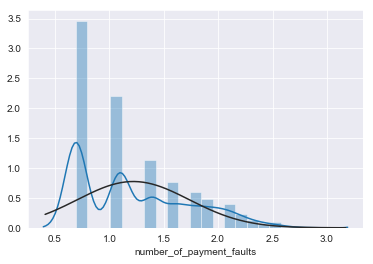

<Figure size 432x288 with 0 Axes>

In [72]:
sns.distplot(df_target['number_of_payment_faults'], fit=norm)
fig = plt.figure()

In [73]:
df_target['number_of_payment_faults'].unique()

array([0.69314718, 1.09861229, 2.48490665, 2.07944154, 1.94591015,
       1.38629436, 1.79175947, 1.60943791, 2.19722458, 2.56494936,
       2.30258509, 2.39789527, 2.77258872, 2.89037176, 2.7080502 ,
       2.63905733])

- ### Remove 'contract_nr'
'contract_nr' will not be used as a feature to train a classifier

In [74]:
df_train_contract_nr = pd.DataFrame(index = df_train.index, columns=['contract_nr']) 
df_train_contract_nr['contract_nr'] = df_train['contract_nr']

df_test_contract_nr  = pd.DataFrame(index = df_test.index, columns=['contract_nr'])
df_test_contract_nr['contract_nr'] = df_test['contract_nr']

In [75]:
df_train.drop(['contract_nr'], axis=1, inplace=True)
df_test.drop(['contract_nr'], axis=1, inplace=True)

In [76]:
print("Training set size:", df_train.shape)
print("Training target set size:", df_target.shape)
print("Test set size:", df_test.shape)

Training set size: (4789, 138)
Training target set size: (4789, 1)
Test set size: (23161, 138)


- ### Remove highly correlated features

In [77]:
#plt.figure(figsize=(15, 15))
#ax = sns.heatmap(df_train.corr(), vmax=.8, square=True, fmt='.2f', annot=True, linecolor='white', linewidths=0.01)
#plt.title('Cross correlation between variables')
#plt.show()

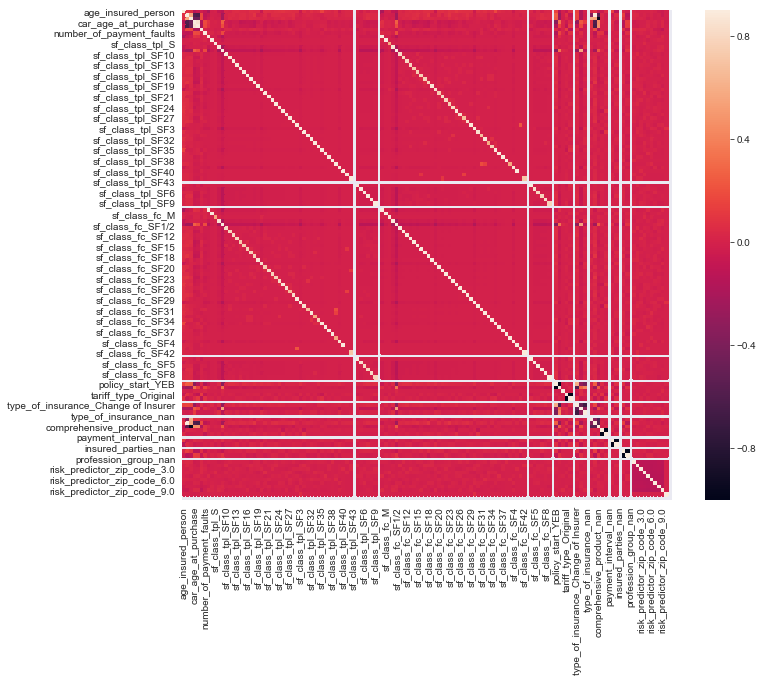

In [78]:
#Correlation map to see how features are correlated with SalePrice
corrmat = df_train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

## 3. Modelling

**Reference**

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

https://xgboost.readthedocs.io/en/release_0.72/tutorials/model.html

https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d

https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/

- ### Prepare train and test sets

In [79]:
df_train.columns

Index(['age_insured_person', 'fc_deductible', 'pc_deductible',
       'car_age_at_purchase', 'car_age_contract_start', 'annual_mileage',
       'number_of_payment_faults', 'sf_class_tpl_0', 'sf_class_tpl_M',
       'sf_class_tpl_S',
       ...
       'risk_predictor_zip_code_2.0', 'risk_predictor_zip_code_3.0',
       'risk_predictor_zip_code_4.0', 'risk_predictor_zip_code_5.0',
       'risk_predictor_zip_code_6.0', 'risk_predictor_zip_code_7.0',
       'risk_predictor_zip_code_8.0', 'risk_predictor_zip_code_9.0',
       'risk_predictor_zip_code_nan', 'risk_predictor_zip_code_nan'],
      dtype='object', length=138)

In [80]:
y_train = df_target['number_of_payment_faults'].values
x_train = df_train.drop(['number_of_payment_faults'], axis=1)

x_test = df_test.drop(['number_of_payment_faults'], axis=1)

In [81]:
x_train.shape

(4789, 137)

In [82]:
y_train.shape

(4789,)

In [83]:
x_test.shape

(23161, 137)

- ### Define a cross validation strategy

In [84]:
def rmsle_cv(model, train=x_train, y_train=y_train, n_folds=3):
    
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    
    return(rmse)

In [102]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

- #### LASSO Regression

Use sklearn's Robustscaler() method on pipeline in order to make the model robusst to outliers.

In [85]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=42))

- #### Elastic Net Regression


In [86]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=42))

- #### Kernel Ridge Regression

In [87]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

- #### Gradient Boosting Regression 

With huber loss to make it robust to outliers

In [88]:
GBoost = GradientBoostingRegressor(n_estimators=200, 
                                   learning_rate=0.05,
                                   max_depth=4, 
                                   max_features='sqrt',
                                   min_samples_leaf=15, 
                                   min_samples_split=10, 
                                   loss='huber', 
                                   random_state =42)

- #### XGBoost

In [89]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, 
                             gamma=0.0468, 
                             learning_rate=0.05, 
                             max_depth=3, 
                             min_child_weight=1.7817, 
                             n_estimators=200,
                             reg_alpha=0.4640, 
                             reg_lambda=0.8571,
                             subsample=0.5213, 
                             silent=1,
                             random_state =42, 
                             nthread = 4)

- #### lightGBM

In [90]:
model_lgb = lgb.LGBMRegressor(objective='regression',
                              num_leaves=5,
                              learning_rate=0.05, 
                              n_estimators=100,
                              max_bin = 55, 
                              bagging_fraction = 0.8,
                              bagging_freq = 5, 
                              feature_fraction = 0.2319,
                              feature_fraction_seed=9, 
                              bagging_seed=9,
                              min_data_in_leaf =6, 
                              min_sum_hessian_in_leaf = 11)

- #### Random forest

In [91]:
model_rf = RandomForestRegressor(n_estimators=200, 
                                 random_state=42, 
                                 max_depth=4,
                                 #min_weight_fraction_leaf=0.1,
                                 #max_leaf_nodes = 20,
                                 #min_samples_split = 20
                                )

In [92]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.4854 (0.0041)



In [93]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.4855 (0.0041)



In [94]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.4859 (0.0037)



In [95]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.4849 (0.0015)



In [96]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.4840 (0.0028)



In [97]:
#score = rmsle_cv(model_lgb)
#print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

In [98]:
score = rmsle_cv(model_rf)
print("RF score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

RF score: 0.4903 (0.0015)



- ###  Hyperparameter tuning

https://www.kaggle.com/jayatou/xgbregressor-with-gridsearchcv

https://www.kaggle.com/ksjpswaroop/parameter-tuning-rf-randomized-search

In [103]:
regr_xgb = xgb.XGBRegressor()

param_dist = {'objective':['reg:linear'],
              'learning_rate': [0.01, 0.05, 0.07, 0.09], 
              'max_depth': [4, 6, 8],
              'n_estimators': [100, 200, 500],
              'min_child_weight': [2, 4],
              #'silent': [1],
              #'subsample': [0.7],
              #'colsample_bytree': [0.7],
              #'nthread':[4], #when use hyperthread, xgboost may become slower
             }

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
random_search = RandomizedSearchCV(estimator = regr_xgb, 
                                   param_distributions = param_dist, 
                                   n_jobs = 4,
                                   n_iter = 2,
                                   cv = 3,
                                   verbose=2,
                                  )

#xgb_grid = GridSearchCV(xgb1, parameters, cv = 2, n_jobs = 5, verbose=True)
random_search.fit(x_train.values, y_train)

print('xgboost (hyperparameter tuning with random search)')
print(random_search.best_score_)
print(random_search.best_params_)

xgb_random_search_train_pred = random_search.predict(x_train.values)

xgb_random_search_pred = random_search.predict(x_test.values)
xgb_random_search_pred = np.expm1(xgb_random_search_pred)

print(rmsle(y_train, xgb_random_search_train_pred))

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   6 | elapsed:    2.7s remaining:    2.7s
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:    7.0s finished


xgboost (hyperparameter tuning with random search)
0.08333786511551096
{'objective': 'reg:linear', 'n_estimators': 500, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.05}
0.419492481416419


In [105]:
score = rmsle_cv(random_search)
print("xgboost (random search) score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   6 | elapsed:    1.3s remaining:    1.3s
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:    5.9s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   6 | elapsed:    1.8s remaining:    1.8s
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:    7.6s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   6 | elapsed:    6.6s remaining:    6.6s
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:   12.5s finished


xgboost (random search) score: 0.5114 (0.0183)



In [106]:
# random forest
regr_rdf = RandomForestRegressor(n_estimators=18, 
                             random_state=42, 
                             max_depth=3,
                             #min_weight_fraction_leaf=0.1,
                             #max_leaf_nodes = 20,
                             #min_samples_split = 20
                            )

# https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/
# https://stats.stackexchange.com/questions/354336/what-happens-when-bootstrapping-isnt-used-in-sklearn-randomforestclassifier   
param_dist = {"max_depth": [4, 6, 8],
              "n_estimators": [100, 200, 500],
              #"max_features": sp_randint(1, 11),
              #"min_samples_split": sp_randint(2, 11),
              #"min_samples_leaf": sp_randint(1, 11),
              #"bootstrap": [True, False], 
             }


# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
random_search = RandomizedSearchCV(estimator = regr_rdf, 
                                   param_distributions = param_dist, 
                                   n_jobs = 4,
                                   n_iter = 2,
                                   cv = 3,
                                   verbose=2,
                                  )

#xgb_grid = GridSearchCV(xgb1, parameters, cv = 2, n_jobs = 5, verbose=True)
random_search.fit(x_train, y_train)

print('random forest (hyperparameter tuning with random search)')
print(random_search.best_score_)
print(random_search.best_params_)

rf_random_search_train_pred = random_search.predict(x_train.values)

rf_random_search_pred = random_search.predict(x_test.values)
rf_random_search_pred = np.expm1(rf_random_search_pred)

print(rmsle(y_train, rf_random_search_train_pred))

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   6 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:    6.0s finished


random forest (hyperparameter tuning with random search)
0.10096749963779669
{'n_estimators': 100, 'max_depth': 6}
0.46402610534596744


In [107]:
score = rmsle_cv(random_search)
print("RF (random search) score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   6 | elapsed:    1.6s remaining:    1.6s
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:    1.9s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   6 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:    2.1s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   6 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:    1.5s finished


RF (random search) score: 0.4884 (0.0015)



- ### Stacking

The code is taken from

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

- #### Averaged base models class

In [682]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

- #### Averaged base models score

In [683]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.4842 (0.0034)



- ### More stacking

The code is taken from

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard


1. Split the total training set into two disjoint sets (train and .holdout )

2. Train several base models on the first part (train)

3. Test these base models on the second part (holdout)

4. Use the predictions from 3) (called out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs to train a higher level learner called meta-model.

For the prediction part , we average the predictions of all base models on the test data and used them as meta-features on which, the final prediction is done with the meta-model.


**Reference**

https://www.kaggle.com/getting-started/18153#post103381

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

http://blog.kaggle.com/2017/06/15/stacking-made-easy-an-introduction-to-stacknet-by-competitions-grandmaster-marios-michailidis-kazanova/




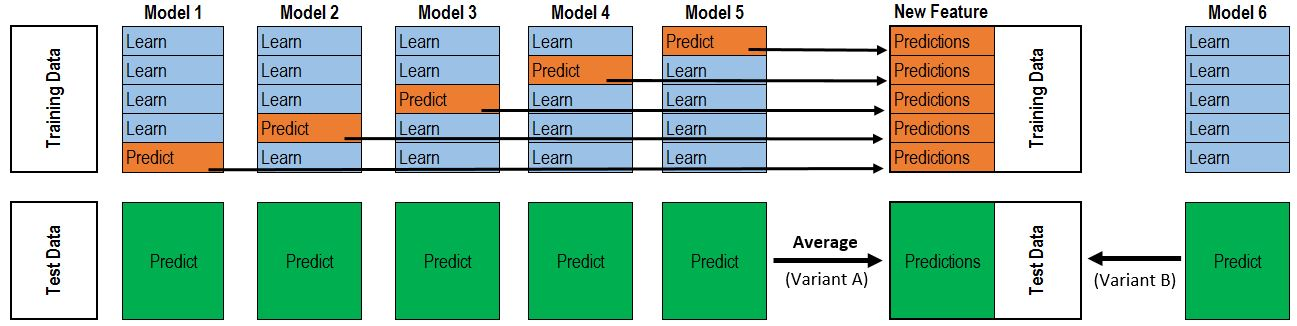

In [684]:
# https://nbsphinx.readthedocs.io/en/0.1.0/example.html
from IPython.display import display, Image, SVG, Math, YouTubeVideo
i = Image(filename='stacking.jpg')
i

Image taken from Faron, https://www.kaggle.com/getting-started/18153#post103381

- #### Stacking averaged Models Class

In [685]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

- #### Stacking Averaged models Score

In [686]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.4836 (0.0026)


In [688]:
stacked_averaged_models.fit(x_train.values, y_train)

stacked_train_pred = stacked_averaged_models.predict(x_train.values)

stacked_pred = stacked_averaged_models.predict(x_test.values)
stacked_pred = np.expm1(stacked_pred)

print(rmsle(y_train, stacked_train_pred))

0.46784401105481244


In [689]:
model_xgb.fit(x_train.values, y_train)

xgb_train_pred = model_xgb.predict(x_train.values)

xgb_pred = model_xgb.predict(x_test.values)
xgb_pred = np.expm1(xgb_pred)

print(rmsle(y_train, xgb_train_pred))

0.4629616181577365


In [690]:
model_rf.fit(x_train.values, y_train)

rf_train_pred = model_rf.predict(x_train.values)

rf_pred = model_rf.predict(x_test.values)
rf_pred = np.expm1(rf_pred)

print(rmsle(y_train, rf_train_pred))

0.48226165802239657


- #### Ensemble prediction

In [691]:
ensemble = stacked_pred*0.30 + xgb_pred*0.20 + rf_pred*0.20 + xgb_random_search_pred*0.15 + rf_random_search_pred*0.15

In [694]:
set(np.round(ensemble))

{1.0, 2.0, 3.0, 4.0}

- #### Save prediction

In [695]:
sub = pd.DataFrame()
sub['contract_nr'] = df_test_contract_nr['contract_nr']
sub['number_of_payment_faults'] = np.round(ensemble)

sub.to_excel('output.xlsx', index=False)

In [696]:
df_output = pd.read_excel('output.xlsx')

In [698]:
df_output.head(20)

,contract_nr,number_of_payment_faults
0,2,1
1,3,2
2,4,2
3,5,2
4,6,2
5,7,2
6,8,2
7,9,2
8,10,2
9,11,2
